# W-net Model - Train

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from keras.optimizers import  Adam


# Importing our w-net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import frequency_spatial_network as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

D:\Softwares\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                , 2)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 3, 256, 256,  912         ['input_1[0][0]']                
                                 48)                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 3, 256, 256,  20784       ['conv3d[0][0]']                 
                                 48)                                                          

                                                                                                  
 lambda_1 (Lambda)              (None, 3, 256, 256,  0           ['lambda[0][0]']                 
                                 1)                                                               
                                                                                                  
 lambda_2 (Lambda)              (None, 3, 256, 256,  0           ['lambda_1[0][0]']               
                                 1)                                                               
                                                                                                  
 conv3d_15 (Conv3D)             (None, 3, 256, 256,  480         ['lambda_2[0][0]']               
                                 48)                                                              
                                                                                                  
 conv3d_16

__________________________________________________________________________________________________


In [2]:
import keras
print(keras.__version__)

print(keras.__version__)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2.10.0
2.10.0
Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
print(fsnet.wnet_new(1,2,3,4))

In [4]:
# Train Set 
train_path = r"../../calgary/Train/Train/*.npy"
# train_path = r"D:\Dataset\calgary\Train\Train\e14141s3_P58880.7.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = r"../../calgary/Val/Val/*.npy"
# val_path = r"D:\Dataset\calgary\Val\Val\e14351s3_P29184.7.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

D:\Dataset\calgary\Train\Train\e14141s3_P58880.7.npy
1
D:\Dataset\calgary\Val\Val\e14351s3_P29184.7.npy
1


Undersampling: 0.82293701171875
Mask type: bool


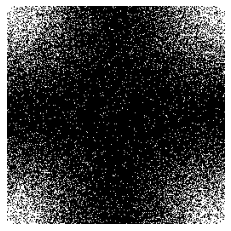

In [5]:
under_rate = '20'
imshape = (256,256)
norm = np.sqrt(imshape[0]*imshape[1])
nchannels = 2 #complex data real + imag

# undersampling patterns - uncentred k-space
var_sampling_mask = np.load("../Data/sampling_mask_" + under_rate + "perc.npy")

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
print("Mask type:",  var_sampling_mask.dtype)
plt.figure()
plt.imshow(~var_sampling_mask,cmap = "gray")
plt.axis("off")
plt.show()

## Load Train Data

In [6]:
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0]
#     ntrain += 168

# Load train data    
rec_train = np.zeros((ntrain,imshape[0],imshape[1],2))
kspace_train = np.zeros((ntrain,imshape[0],imshape[1],2))
aux_counter = 0
for ii in range(len(kspace_files_train)):
    aux_kspace = np.load(kspace_files_train[ii])/norm
    aux = aux_kspace.shape[0]   
    aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
    rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
    rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
    kspace_train[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[:,:,:,0]
    kspace_train[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[:,:,:,1]
    aux_counter+=aux

# Shuffle training    
# indexes = np.arange(rec_train.shape[0],dtype = int)
# np.random.shuffle(indexes)
# rec_train = rec_train[indexes]

kspace_train[:,var_sampling_mask,:] = 0 # undersample k-space

# save k-space and image domain stats
stats = np.zeros(4)
stats[0] = kspace_train.mean()
stats[1] = kspace_train.std()
aux = np.abs(rec_train[:,:,:,0] +1j*rec_train[:,:,:,1])
stats[2] = aux.mean()
stats[3] = aux.std()
np.save("../Data/stats_fs_unet_norm_" + under_rate + ".npy",stats)

print("Number of training samples", rec_train.shape[0])
kspace_train = 0 # release memory

Number of training samples 170


## Load Validation Data

In [7]:
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    nval += np.load(kspace_files_val[ii]).shape[0]

kspace_val = np.zeros((nval,imshape[0],imshape[1],nchannels))
rec_val = np.zeros((nval,imshape[0],imshape[1],1))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = aux_kspace.shape[0]   
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    rec_val[aux_counter:aux_counter+aux,:,:,0] = \
    np.abs(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    aux_counter+=aux

# Undersampling kspace
kspace_val2 = kspace_val.copy()
kspace_val[:,var_sampling_mask,:] = 0

rec_val = np.fft.ifft2(kspace_val[:,:,:,0]+1j*kspace_val[:,:,:,1])
rec_val2 = np.fft.ifft2(kspace_val2[:,:,:,0]+1j*kspace_val2[:,:,:,1])
rec_val = np.expand_dims(rec_val, axis=-1)

kspace_val = (kspace_val-stats[0])/stats[1]

print("Number of samples", kspace_val.shape[0])
print("Kspace under stats", kspace_val.mean(),kspace_val.std())
print("Kspace full stats", kspace_val2.mean(),kspace_val2.std())
print("Rec stats", rec_val.mean(),rec_val.std())

Number of samples 170
Kspace under stats -3.8131164631996625e-05 0.9633251330989995
Kspace full stats 0.09058370222776935 1039.5451611907024
Rec stats (3.6269020378589683+1.7514527901368086e-12j) 4.25529665823789


## Initialize Model

In [8]:
epochs = 1
batch_size= 16 # changing batch size from 16 to 3 for data augmentation
model = fsnet.model1()
opt = Adam(lr=1e-3,decay = 1e-7)
model.compile(loss = fsnet.nrmse,optimizer=opt, metrics=['accuracy'])

model_name = "../Models/wnet_part1.hdf5"
# model_name = r"C:\Users\soggy\Videos\Hybrid-CS-Model-MRI\Models\wnet_part1.hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 48  912         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 48  20784       ['conv2d_2[0][0]']               
                                )                                                           

D:\Softwares\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Data Augmentation

In [9]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(rec_train[:,:,:,0,np.newaxis], augment=True, seed=seed)
image_datagen2.fit(rec_train[:,:,:,1,np.newaxis], augment=True, seed=seed)

image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2,under_mask,stats):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        kspace_under = kspace2.copy()
        kspace_under[:,var_sampling_mask,:] = 0
        kspace_under = (kspace_under-stats[0])/stats[1]
        rec = np.abs(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])[:,:,:,np.newaxis]
        
        rec_under = np.fft.ifft2(kspace_under[:,:,:,0]+1j*kspace_under[:,:,:,1])
        rec_under_expanded = np.expand_dims(rec_under, axis=-1)
#         print(rec_under.shape, rec_under_expanded.shape)
        yield(kspace_under, [kspace2])

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2, var_sampling_mask,stats)

# sample data augmentation
# for ii in combined:
#     print(ii[1][1][1].shape)
#     plt.figure()
#     plt.subplot(221)
#     plt.imshow(ii[1][1][1][:,:,0],cmap = 'gray')
#     plt.axis("off")
#     plt.subplot(222)
#     plt.imshow(ii[1][1][1][:,:,0],cmap = 'gray')
#     plt.axis("off")
#     plt.subplot(223)
#     plt.imshow(ii[1][1][1][:,:,0],cmap = 'gray')
#     plt.axis("off")
#     plt.subplot(224)
#     plt.imshow(np.log(1+np.abs(ii[1][0][1][1,:,:,0] + 1j*ii[1][0][1][1,:,:,1])),cmap = 'gray')
#     plt.axis("off")
#     plt.show()
#     print(ii[1][0].shape)
#     break

## Train model

In [10]:
hist = model.fit_generator(combined,
                 epochs=epochs,
#                  steps_per_epoch=rec_train.shape[0] / batch_size,
                 steps_per_epoch=rec_train.shape[0] / 16,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2]),
                 callbacks=[checkpoint,earlyStopping])

C:\Users\soggy\AppData\Local\Temp\ipykernel_19536\3953586506.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(combined,


11/10 [===============================] - ETA: -4s - batch: 5.0000 - size: 15.4545 - loss: 0.9991 - acc: 0.5926

D:\Softwares\Anaconda\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


10/10 [==============================] - 179s 17s/step - batch: 5.0000 - size: 15.4545 - loss: 0.9991 - acc: 0.5926 - val_loss: 0.9990 - val_acc: 0.5958


In [11]:
print(hist.history)

{'loss': [0.9990649048019858], 'acc': [0.59255450963974], 'val_loss': [0.9990233147845549], 'val_acc': [0.5957669615745544]}


In [12]:
# model.save(r"C:\Users\soggy\Videos\Hybrid-CS-Model-MRI\Models\wnet_part1.hdf5")